
# Functional → Anatomy → HCR Mapping (Zebrafish, 2P + HCR)

This notebook automates a practical pipeline to map motion-corrected functional planes to the best matching **2P anatomy** Z-plane and then into **HCR/confocal** space.

**Core steps**
1. Build a *crisp* per-plane functional reference using a Suite2p-style **top‑correlated mean**.
2. For each plane, find the **best matching Z** in the 2P anatomy stack via **normalized cross‑correlation**.
3. Estimate an **in‑plane transform** (shift/similarity) from functional reference → anatomy[best‑Z].
4. Apply a precomputed **3D warp** (anatomy → HCR) to place the functional plane/slab into HCR space.
5. Transfer **ROI labels** (nearest‑neighbor) or **fluorescence images** (linear) as appropriate.

> Tip: Set the voxel sizes (µm) correctly for both stacks before registration, and keep a record of transforms so you can compose and resample **once** wherever possible.



## Requirements

This notebook uses common scientific Python packages:

- `numpy`, `scipy`, `pandas`
- `tifffile`
- `scikit-image` (`skimage`)
- `opencv-python` (optional; speeds up template matching)
- `matplotlib` for quick QA plots

If an import fails, install the package in your environment and re-run the cell.


In [2]:

import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite, TiffFile
from skimage import filters, exposure, transform, feature, measure, registration, img_as_float32
from skimage.transform import SimilarityTransform, AffineTransform, warp
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

# Optional OpenCV (accelerated NCC); guarded import
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

import matplotlib.pyplot as plt

print("HAS_CV2:", HAS_CV2)


HAS_CV2: True



## Paths & I/O

Edit these to your data. You can also point to your colleague's helper notebook (`/mnt/data/fToA_registration_jl.ipynb`) if you want to copy functions from it.


In [3]:

# --- User paths (EDIT ME) ---
INPUT_DIR = Path('/Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/input')
OUTDIR = Path('/Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/output'); OUTDIR.mkdir(exist_ok=True, parents=True)

# Default input files inside INPUT_DIR
FUNC_STACK_PATH = INPUT_DIR / 'L395_f11_plane0_mcorrected_flipX_substack.tif'   # motion-corrected, single plane over time OR volume over time
ANAT_STACK_PATH = INPUT_DIR / 'L395_f11_anatomy_2P_GCaMP.tif'   # 2P anatomy (structural) stack
# HCR_STACK_PATH  = INPUT_DIR / 'hcr_stack.tif'          # HCR/confocal stack (already cleared sample)

# Optional label image to map (e.g., Cellpose labels)
LABELS_PATH = None   # e.g., INPUT_DIR / 'cellpose_labels.tif' (uint16 IDs)

# Cellpose/segmentation masks (functional 2D, anatomy 3D)
FUNC_LABELS_PATH = INPUT_DIR / 'AVG_L395_f11_plane0_mcorrected_flipX_substack_cp_masks.png'   # per-pixel int IDs (0=bg)
ANAT_LABELS_PATH = INPUT_DIR / 'L395_f11_anatomy_00001_8bit_cp_masks.tif'   # 3D labels stack (Z,Y,X)

# Voxel sizes are inferred from image metadata and cached (see next cell).

# Reference building strategy for functional plane: 'time_mean' or 'topcorr'
REF_BUILD_STRATEGY = globals().get('REF_BUILD_STRATEGY', 'time_mean')
# Toggle: if True, rescale functional reference to anatomy XY before NCC (can blur and sometimes hurt feature matching).
RESCALE_FOR_NCC = False
# If detection fails or you want to override, set these manual values (µm). Leave None to skip an axis.
VOX_FUNC_MANUAL = { 'X': 0.6166852, 'Y': 0.6166852 }  # functional (XY only)
VOX_ANAT_MANUAL = { 'X': 0.5964025, 'Y': 0.5964025, 'Z': 2.0 } # anatomy (XYZ)

# Random seed for reproducibility in frame subsampling
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)



## Utility functions


In [4]:

def zproject_mean(stack):
    return stack.mean(axis=0)

def norm01(img):
    img = img.astype(np.float32)
    m, M = np.percentile(img, (1, 99))
    if M <= m:
        M = img.max(); m = img.min()
    out = np.clip((img - m) / (M - m + 1e-6), 0, 1)
    return out

def local_unsharp(img, blur_sigma=1.0, amount=0.6):
    base = ndi.gaussian_filter(img, blur_sigma)
    return np.clip(base + amount*(img - base), 0, 1)

def corrcoef_img(a, b):
    # Pearson correlation between 2D arrays
    a = a.astype(np.float32); b = b.astype(np.float32)
    am = a.mean(); bm = b.mean()
    num = ((a - am)*(b - bm)).sum()
    den = np.sqrt(((a - am)**2).sum() * ((b - bm)**2).sum()) + 1e-8
    return float(num / den)

def top_correlated_mean(stack_t, take_k=20, pre_smooth_sigma=0.5):
    """Suite2p-like: build crisp reference by selecting top-K frames most correlated to a provisional mean."""
    T, H, W = stack_t.shape
    # Provisional mean
    m0 = stack_t.mean(axis=0)
    # Optional pre-smoothing to reduce shot noise
    if pre_smooth_sigma and pre_smooth_sigma > 0:
        m0s = ndi.gaussian_filter(m0, pre_smooth_sigma)
    else:
        m0s = m0
    # Correlate each frame with provisional mean
    corrs = np.empty(T, dtype=np.float32)
    for i in range(T):
        fi = stack_t[i]
        if pre_smooth_sigma and pre_smooth_sigma > 0:
            fi = ndi.gaussian_filter(fi, pre_smooth_sigma)
        corrs[i] = corrcoef_img(fi, m0s)
    # Take top-K
    k = min(take_k, T)
    idx = np.argsort(corrs)[-k:]
    ref = stack_t[idx].mean(axis=0)
    return ref, idx, corrs

def best_z_by_ncc(template, anat_stack, use_cv2=True):
    """Return best Z index and NCC scores over Z for a 2D template vs 3D stack."""
    template = norm01(template)
    H, W = template.shape
    scores = []
    if use_cv2 and HAS_CV2:
        templ = (template*255).astype(np.uint8)
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            sl8 = (sl*255).astype(np.uint8)
            res = cv2.matchTemplate(sl8, templ, cv2.TM_CCORR_NORMED)
            # Whole-image match: template same size; if not, pad template or crop; here we assume same FOV/size
            if res.size == 1:
                s = float(res.ravel()[0])
            else:
                s = float(res.max())
            scores.append(s)
    else:
        # fallback: simple correlation on same-size images
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            s = corrcoef_img(template, sl)
            scores.append(s)
    scores = np.asarray(scores, dtype=np.float32)
    best_z = int(np.argmax(scores))
    return best_z, scores

def estimate_inplane_transform(mov, ref, method='similarity'):
    """Estimate 2D transform from moving image (mov) to reference (ref).
    Tries ORB+RANSAC; falls back to phase cross-correlation (shift only)."""
    m = norm01(mov); r = norm01(ref)
    # ORB keypoints
    try:
        detector = feature.ORB(n_keypoints=2000, fast_threshold=0.05)
        detector.detect_and_extract(img_as_float32(m))
        kp1 = detector.keypoints; d1 = detector.descriptors
        detector.detect_and_extract(img_as_float32(r))
        kp2 = detector.keypoints; d2 = detector.descriptors
        if len(kp1) >= 10 and len(kp2) >= 10 and d1 is not None and d2 is not None:
            matches12 = feature.match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
            src = kp1[matches12[:, 0]][:, ::-1]  # (x,y)
            dst = kp2[matches12[:, 1]][:, ::-1]
            if method == 'similarity':
                model, inliers = measure.ransac((src, dst), SimilarityTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            else:
                model, inliers = measure.ransac((src, dst), AffineTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            if model is not None:
                return model
    except Exception as e:
        pass
    # Fallback: phase correlation for shift
    shift, _, _ = registration.phase_cross_correlation(r, m, upsample_factor=10)
    tform = SimilarityTransform(translation=(shift[1], shift[0]))
    return tform

def refine_affine_ecc(mov, ref, init_tform=None, max_iters=200, eps=1e-6, pyr_levels=3):
    """Refine an in-plane transform with OpenCV ECC (intensity-based), using affine model.
    Returns an AffineTransform that maps mov → ref.
    Strategy: pre-warp mov with init_tform into ref-shape, then run ECC starting from identity; compose.
    """
    if not HAS_CV2:
        return init_tform if init_tform is not None else AffineTransform()
    r = img_as_float32(norm01(ref))
    # Pre-warp moving with init transform to match ref shape (if provided)
    if init_tform is None:
        m0 = img_as_float32(norm01(mov))
        if m0.shape != r.shape:
            m0 = transform.resize(m0, r.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        W_init = np.eye(3, dtype=np.float32)
    else:
        m0 = apply_transform_2d(img_as_float32(norm01(mov)), init_tform, output_shape=r.shape, order=1)
        W_init = init_tform.params.astype(np.float32)
    # ECC from identity
    W_ecc = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, int(max_iters), float(eps))
    try:
        cc, Wopt = cv2.findTransformECC(r, m0, W_ecc, cv2.MOTION_AFFINE, criteria, None, pyr_levels)
        A_ecc = np.eye(3, dtype=np.float32); A_ecc[:2, :]= Wopt
        # Compose: first init, then ECC refinement in ref frame
        A_final = A_ecc @ W_init
        return AffineTransform(matrix=A_final)
    except Exception:
        return init_tform if init_tform is not None else AffineTransform()

def apply_transform_2d(img, tform, output_shape=None, order=1, preserve_range=True):
    if output_shape is None:
        output_shape = img.shape
    warped = warp(img, inverse_map=tform.inverse, output_shape=output_shape, order=order,
                  preserve_range=preserve_range, mode='constant', cval=0.0, clip=True)
    return warped

def resample_labels_nn(img, tform, output_shape=None):
    # nearest-neighbor for label images
    return apply_transform_2d(img, tform, output_shape=output_shape, order=0, preserve_range=True)

def apply_anat_to_hcr_warp_2d(slice_img, z_index, warp3d_func):
    """Hook to apply a 3D warp (anatomy→HCR) to a 2D slice.
    `warp3d_func` should accept (z,y,x) indices or coordinates and return warped image in HCR coords.
    For now this is a placeholder you can implement with your BigWarp/ANTs output.
    """
    return warp3d_func(slice_img, z_index)

def quickshow(img, title='', vmin=None, vmax=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img, vmin=vmin, vmax=vmax)
    plt.title(title); plt.axis('off'); plt.show()

def _to_um(val, unit):
    try:
        v = float(val)
    except Exception:
        return None
    if unit is None:
        return None
    u = str(unit).lower()
    if u in ('µm', 'um', 'micron', 'micrometer', 'micrometre'):
        return v
    if u in ('nm', 'nanometer', 'nanometre'):
        return v / 1000.0
    if u in ('mm', 'millimeter', 'millimetre'):
        return v * 1000.0
    if u in ('cm', 'centimeter', 'centimetre'):
        return v * 10000.0
    if u in ('in', 'inch', 'inches'):
        return v * 25400.0
    return None

def _res_to_um_per_px(res_tag, unit_tag):
    try:
        num, den = getattr(res_tag, 'value', (None, None))
        if num is None or den is None:
            v = float(getattr(res_tag, 'value', None))
            ppu = v
        else:
            ppu = float(num) / float(den)
    except Exception:
        return None
    unit_val = getattr(unit_tag, 'value', unit_tag)
    try:
        u = str(unit_val).upper()
    except Exception:
        u = 'NONE'
    if u == '2' or 'INCH' in u:
        return 25400.0 / ppu
    if u == '3' or 'CENTIMETER' in u or 'CM' in u:
        return 10000.0 / ppu
    return None

def infer_voxels_tiff(path):
    vox = {'Z': None, 'Y': None, 'X': None}
    try:
        with TiffFile(str(path)) as tf:
            # OME-XML
            omexml = None
            try:
                omexml = tf.ome_metadata
            except Exception:
                omexml = None
            if omexml:
                try:
                    import xml.etree.ElementTree as ET
                    root = ET.fromstring(omexml)
                    # find any Pixels element regardless of namespace
                    pix = root.find('.//{*}Pixels')
                    if pix is not None:
                        px = pix.attrib.get('PhysicalSizeX'); pxu = pix.attrib.get('PhysicalSizeXUnit')
                        py = pix.attrib.get('PhysicalSizeY'); pyu = pix.attrib.get('PhysicalSizeYUnit')
                        pz = pix.attrib.get('PhysicalSizeZ'); pzu = pix.attrib.get('PhysicalSizeZUnit')
                        if py is not None:
                            v = _to_um(py, pyu or 'um')
                            if v: vox['Y'] = v
                        if px is not None:
                            v = _to_um(px, pxu or 'um')
                            if v: vox['X'] = v
                        if pz is not None:
                            v = _to_um(pz, pzu or 'um')
                            if v: vox['Z'] = v
                except Exception:
                    pass
            # ImageJ metadata (Z spacing)
            try:
                ij = tf.imagej_metadata or {}
                if isinstance(ij, dict):
                    zsp = ij.get('spacing', None)
                    unit = ij.get('unit', 'um')
                    if vox['Z'] is None and zsp is not None:
                        vz = _to_um(zsp, unit)
                        if vz: vox['Z'] = vz
            except Exception:
                pass
            # Resolution tags → X/Y
            try:
                page0 = tf.pages[0]
                xr = page0.tags.get('XResolution', None)
                yr = page0.tags.get('YResolution', None)
                ru = page0.tags.get('ResolutionUnit', None)
                if vox['X'] is None and xr is not None and ru is not None:
                    vx = _res_to_um_per_px(xr, ru)
                    if vx: vox['X'] = vx
                if vox['Y'] is None and yr is not None and ru is not None:
                    vy = _res_to_um_per_px(yr, ru)
                    if vy: vox['Y'] = vy
            except Exception:
                pass
            # Parse ImageDescription for XY pixel size if still missing
            try:
                page0 = tf.pages[0]
                desc = None
                try:
                    desc = page0.description
                except Exception:
                    pass
                if desc is None:
                    try:
                        tag = page0.tags.get('ImageDescription', None)
                        desc = getattr(tag, 'value', None)
                    except Exception:
                        desc = None
                if desc is not None:
                    try:
                        text = desc.decode('utf-8', 'ignore') if isinstance(desc, (bytes, bytearray)) else str(desc)
                    except Exception:
                        text = str(desc)
                    kv = {}
                    for line in text.replace('\r', '\n').split('\n'):
                        if '=' in line:
                            k, v = line.split('=', 1)
                            kv[k.strip()] = v.strip()
                    unit = kv.get('unit', kv.get('Unit', 'um'))
                    px = kv.get('pixelWidth') or kv.get('PixelWidth') or kv.get('XPixelSize') or kv.get('micronsPerPixelX') or kv.get('MicronsPerPixelX') or kv.get('umPerPixelX') or kv.get('UmPerPixelX') or kv.get('X_UM_PER_PIXEL')
                    py = kv.get('pixelHeight') or kv.get('PixelHeight') or kv.get('YPixelSize') or kv.get('micronsPerPixelY') or kv.get('MicronsPerPixelY') or kv.get('umPerPixelY') or kv.get('UmPerPixelY') or kv.get('Y_UM_PER_PIXEL')
                    both = kv.get('PixelSizeUm') or kv.get('pixelSizeUm') or kv.get('PixelSize')
                    if both is not None:
                        try:
                            val = float(both)
                            if vox['X'] is None: vox['X'] = val
                            if vox['Y'] is None: vox['Y'] = val
                        except Exception:
                            pass
                    if vox['X'] is None and px is not None:
                        vx = _to_um(px, unit)
                        if vx: vox['X'] = vx
                    if vox['Y'] is None and py is not None:
                        vy = _to_um(py, unit)
                        if vy: vox['Y'] = vy
            except Exception:
                pass
    except Exception:
        pass
    # 5) Final fallback: try ANTs (as in antsQC) if available; works for NRRD/TIFF and reads spacing header
    try:
        import ants  # type: ignore
        img = ants.image_read(str(path))
        sp = tuple(float(s) for s in img.spacing)  # (dx,dy[,dz])
        if len(sp) >= 2:
            if vox['X'] is None: vox['X'] = sp[0]*1.0  # dx (µm)
            if vox['Y'] is None: vox['Y'] = sp[1]*1.0  # dy (µm)
        if len(sp) >= 3 and vox['Z'] is None:
            vox['Z'] = sp[2]*1.0  # dz (µm)
    except Exception:
        pass
    return vox

def load_or_cache_voxels(path, alias):
    cache = {}
    if VOX_CACHE_PATH.exists():
        try:
            with open(VOX_CACHE_PATH, 'r') as f:
                cache = json.load(f)
        except Exception:
            cache = {}
    by_path = cache.get('by_path', {})
    pkey = str(Path(path))
    if pkey in by_path:
        cached = by_path[pkey]
        # If cached entry is incomplete, try to re-infer now
        try:
            incomplete = cached is None or any(cached.get(ax) is None for ax in ('X','Y','Z'))
        except Exception:
            incomplete = True
        if not incomplete:
            return cached
        # Re-infer and update cache
        vox = infer_voxels_tiff(path)
        cache['by_path'][pkey] = vox
        cache.setdefault('by_alias', {})[alias] = vox
        try:
            with open(VOX_CACHE_PATH, 'w') as f:
                json.dump(cache, f, indent=2)
        except Exception:
            pass
        return vox
    vox = infer_voxels_tiff(path)
    cache.setdefault('by_path', {})[pkey] = vox
    cache.setdefault('by_alias', {})[alias] = vox
    try:
        with open(VOX_CACHE_PATH, 'w') as f:
            json.dump(cache, f, indent=2)
    except Exception:
        pass
    return vox

def rescale_to_match_xy(img, vox_src, vox_dst, order=1):
    try:
        sy = float(vox_src.get('Y')) / float(vox_dst.get('Y'))
        sx = float(vox_src.get('X')) / float(vox_dst.get('X'))
    except Exception:
        return img
    if not np.isfinite(sy) or not np.isfinite(sx):
        return img
    if abs(sy - 1.0) < 1e-3 and abs(sx - 1.0) < 1e-3:
        return img
    out_shape = (max(1, int(round(img.shape[0] * sy))), max(1, int(round(img.shape[1] * sx))))
    return transform.resize(img, out_shape, order=order, preserve_range=True, anti_aliasing=True).astype(np.float32)    

def _ensure_uint_labels(arr):
    arr = np.asarray(arr)
    if not np.issubdtype(arr.dtype, np.integer):
        arr = arr.astype(np.int64)
    return arr

def _regionprops_centroids_2d(label_img):
    tbl = measure.regionprops_table(label_img, properties=['label', 'centroid'])
    df = pd.DataFrame(tbl).rename(columns={'centroid-0': 'cy', 'centroid-1': 'cx'})
    df = df[df['label'] != 0].reset_index(drop=True)
    return df

def _apply_tform_points_xy(tform, x, y):
    pts = np.stack([x, y], axis=1)
    pts_t = tform(pts)
    return pts_t[:,0], pts_t[:,1]

def diameters_um_from_array(arr, vox, axis_order=('Z','Y','X')):
    """Compute per-label diameters along Z/Y/X in µm from a 3D label array.
    Expects vox like {'Z': dz, 'Y': dy, 'X': dx}.
    """
    from skimage.measure import regionprops_table
    arr = np.asarray(arr)
    if arr.ndim != 3:
        raise ValueError('diameters_um_from_array expects a 3D label array (Z,Y,X)')
    props = regionprops_table(arr, properties=('label','bbox'))
    df = pd.DataFrame(props)
    if df.empty:
        return pd.DataFrame(columns=['label','z_um','y_um','x_um'])
    df = df.rename(columns={
        'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin',
        'bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'
    })
    dz = float(vox.get('Z', 1.0)); dy = float(vox.get('Y', 1.0)); dx = float(vox.get('X', 1.0))
    df['z_um'] = (df['zmax'] - df['zmin']) * dz
    df['y_um'] = (df['ymax'] - df['ymin']) * dy
    df['x_um'] = (df['xmax'] - df['xmin']) * dx
    df = df[['label','z_um','y_um','x_um']].copy()
    df['label'] = df['label'].astype(int)
    return df


In [5]:
# Infer and cache voxel sizes (µm) for func/anat[/HCR]
VOX_CACHE_PATH = OUTDIR / 'voxel_sizes.json'

# Detect from headers (fast, cached)
detF = load_or_cache_voxels(FUNC_STACK_PATH, 'func') if FUNC_STACK_PATH else {}
detA = load_or_cache_voxels(ANAT_STACK_PATH, 'anat') if ANAT_STACK_PATH else {}
detH = load_or_cache_voxels(HCR_STACK_PATH,  'hcr') if 'HCR_STACK_PATH' in globals() and HCR_STACK_PATH else {}

# Start from detected values
VOX_FUNC = dict(detF or {})
VOX_ANAT = dict(detA or {})
VOX_HCR  = dict(detH or {}) if detH else None

# Manual overrides (fill per-axis if provided)
if isinstance(globals().get('VOX_FUNC_MANUAL', None), dict):
    for ax in ('X','Y','Z'):
        v = VOX_FUNC_MANUAL.get(ax)
        if v is not None:
            try: VOX_FUNC[ax] = float(v)
            except Exception: VOX_FUNC[ax] = v
if isinstance(globals().get('VOX_ANAT_MANUAL', None), dict):
    for ax in ('X','Y','Z'):
        v = VOX_ANAT_MANUAL.get(ax)
        if v is not None:
            try: VOX_ANAT[ax] = float(v)
            except Exception: VOX_ANAT[ax] = v

print('Voxel sizes (µm): func=', VOX_FUNC, 'anat=', VOX_ANAT, 'hcr=', VOX_HCR)

Voxel sizes (µm): func= {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852} anat= {'Z': 2.0, 'Y': 0.5964025, 'X': 0.5964025} hcr= None



## 1) Build a crisp functional reference per plane

If your functional input is **single-plane over time**: this outputs one reference.  
If it's **volume over time**: set `PLANE_INDEX` to the plane you want, or loop planes.


Functional shape: (1000, 512, 512)
Saved reference to /Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/output/func_ref_plane0.tif


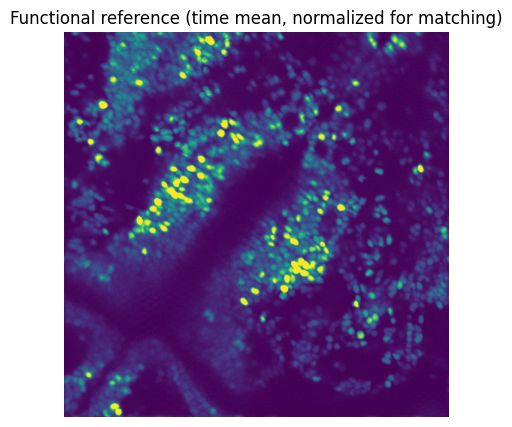

In [6]:

# Load functional data
func = imread(FUNC_STACK_PATH)
print("Functional shape:", func.shape)

# Detect dimensionality: (T, Y, X) or (T, Z, Y, X)
if func.ndim == 3:
    # Single plane over time
    T, H, W = func.shape
    # Non-normalized time mean used for output/warping
    ref2d_raw = func.mean(axis=0).astype(np.float32)
    imwrite(OUTDIR/'func_ref_plane0_raw.tif', ref2d_raw.astype(np.float32))
    # Normalized copy (for matching/visualization)
    ref2d = norm01(ref2d_raw)
    imwrite(OUTDIR/'func_ref_plane0.tif', (ref2d*65535).astype(np.uint16))
    print(f"Saved reference to {OUTDIR/'func_ref_plane0.tif'}")
    quickshow(ref2d, "Functional reference (time mean, normalized for matching)")
else:
    # Volume over time
    T, Z, H, W = func.shape
    PLANE_INDEX = 0  # EDIT: choose plane
    plane_t = func[:, PLANE_INDEX, :, :]
    # Non-normalized time mean for selected plane
    ref2d_raw = plane_t.mean(axis=0).astype(np.float32)
    imwrite(OUTDIR/f'func_ref_plane{PLANE_INDEX}_raw.tif', ref2d_raw.astype(np.float32))
    # Normalized copy (for matching/visualization)
    ref2d = norm01(ref2d_raw)
    imwrite(OUTDIR/f'func_ref_plane{PLANE_INDEX}.tif', (ref2d*65535).astype(np.uint16))
    print(f"Saved reference to {OUTDIR/f'func_ref_plane{PLANE_INDEX}.tif'}")
    quickshow(ref2d, f"Functional reference (time mean, normalized for matching, plane {PLANE_INDEX})")



## 2) Find the best matching Z in the 2P anatomy stack
We correlate the functional reference against each anatomy slice and take the Z with the maximum NCC.


Anatomy shape: (216, 750, 750)
Best Z in anatomy: 124


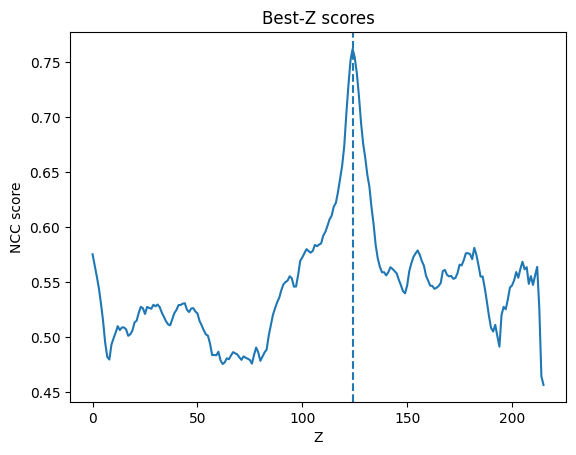

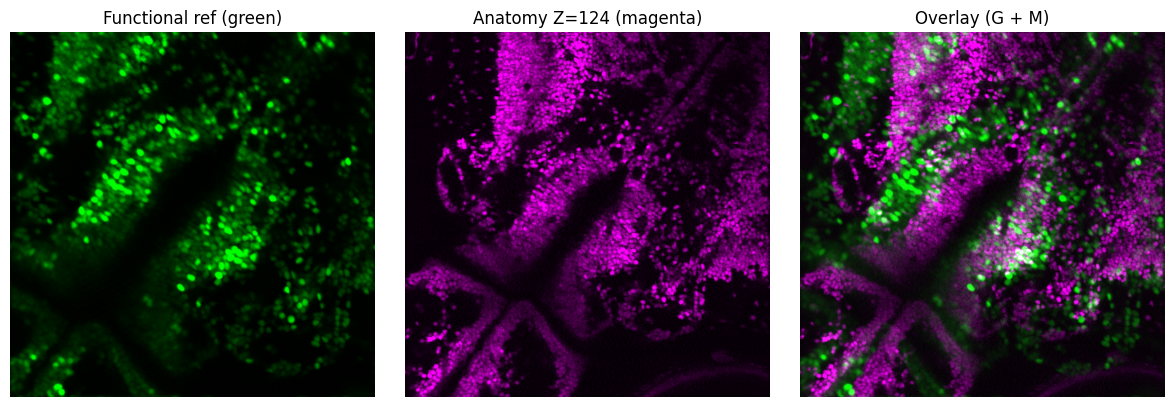

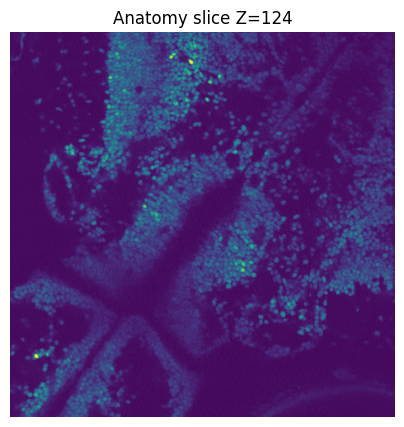

In [7]:

anat = imread(ANAT_STACK_PATH)
print("Anatomy shape:", anat.shape)

# Optional pre-filter to enhance structure
anat_f = np.stack([local_unsharp(norm01(s), 1.0, 0.6) for s in anat], axis=0)
# Use normalized reference only for matching/transform estimation
ref_match  = local_unsharp(norm01(ref2d_raw), 1.0, 0.6)

# Optional: rescale functional reference to match anatomy XY before NCC
if RESCALE_FOR_NCC:
    try:
        if 'VOX_FUNC' in globals() and 'VOX_ANAT' in globals() and VOX_FUNC and VOX_ANAT:
            _sy = float(VOX_FUNC.get('Y', 1.0)) / float(VOX_ANAT.get('Y', 1.0))
            _sx = float(VOX_FUNC.get('X', 1.0)) / float(VOX_ANAT.get('X', 1.0))
            print(f'Rescale for NCC: sy={_sy:.4f}, sx={_sx:.4f}, ref shape {ref_match.shape}')
            ref_match = rescale_to_match_xy(ref_match, VOX_FUNC, VOX_ANAT)
            print(f'→ Rescaled ref shape {ref_match.shape}')
    except Exception as _e:
        print('Warning: voxel-based rescale skipped:', _e)

best_z, scores = best_z_by_ncc(ref_match, anat_f, use_cv2=True)
print("Best Z in anatomy:", best_z)

# Save scores for QA
pd.Series(scores).to_csv(OUTDIR/'bestZ_scores.csv', index=False)

plt.figure()
plt.plot(scores); plt.axvline(best_z, linestyle='--')
plt.xlabel('Z'); plt.ylabel('NCC score'); plt.title('Best-Z scores')
plt.show()

# Sanity check: visualize functional ref (green) vs anatomy best-Z (magenta)
f_vis = norm01(ref2d)
a_vis = norm01(anat[best_z])
# Harmonize shapes for overlay — resize functional to anatomy slice shape if needed
if f_vis.shape != a_vis.shape:
    try:
        f_vis = transform.resize(f_vis, a_vis.shape, order=1, mode='reflect',
                                 preserve_range=True, anti_aliasing=True).astype(np.float32)
    except Exception as _e:
        # Fallback: center-crop both to common min size
        th, tw = min(f_vis.shape[0], a_vis.shape[0]), min(f_vis.shape[1], a_vis.shape[1])
        def _cc(img, th, tw):
            h, w = img.shape; y0 = max(0, (h-th)//2); x0 = max(0, (w-tw)//2); return img[y0:y0+th, x0:x0+tw]
        f_vis = _cc(f_vis, th, tw); a_vis = _cc(a_vis, th, tw)
func_rgb = np.stack([np.zeros_like(f_vis), f_vis, np.zeros_like(f_vis)], axis=-1)
anat_rgb = np.stack([a_vis, np.zeros_like(a_vis), a_vis], axis=-1)
overlay = np.clip(func_rgb + anat_rgb, 0, 1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(func_rgb); plt.title('Functional ref (green)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(anat_rgb); plt.title(f'Anatomy Z={best_z} (magenta)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(overlay); plt.title('Overlay (G + M)'); plt.axis('off')
plt.tight_layout(); plt.show()

quickshow(anat[best_z], f'Anatomy slice Z={best_z}')



## 3) Estimate in-plane transform (functional → anatomy[best‑Z])
We try ORB+RANSAC to get a **similarity** (shift/scale/rotation) transform, and fall back to phase correlation (shift only).



## Compare functional projections (normalized vs raw)

Side-by-side view to sanity-check normalization effects before overlay.

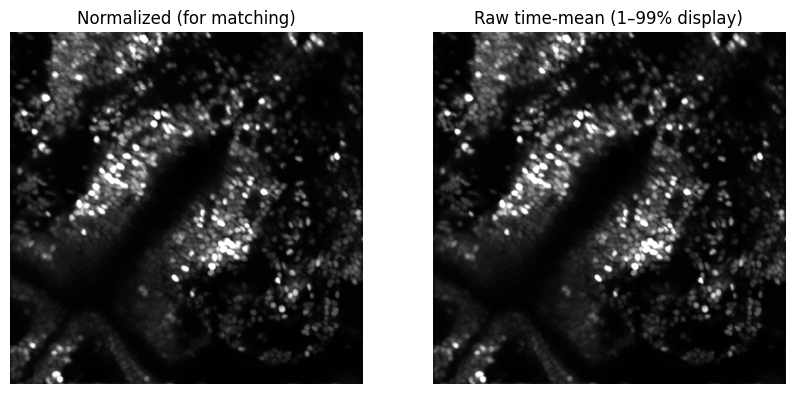

In [8]:

# Compare normalized reference (ref2d) and non-normalized mean (ref2d_raw)
import numpy as _np
import matplotlib.pyplot as _plt
_plt.figure(figsize=(10,5))
_plt.subplot(1,2,1); _plt.imshow(ref2d, cmap='gray', vmin=0, vmax=1); _plt.title('Normalized (for matching)'); _plt.axis('off')
vmin, vmax = _np.percentile(ref2d_raw.astype(_np.float32), (1,99))
_plt.subplot(1,2,2); _plt.imshow(ref2d_raw, cmap='gray', vmin=vmin, vmax=vmax); _plt.title('Raw time-mean (1–99% display)'); _plt.axis('off')
_plt.show()


Similarity tform: [[ 1.04401984e+00 -6.36284211e-03  1.22111876e+02]
 [ 6.36284211e-03  1.04401984e+00  1.26645889e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Affine (RANSAC) tform: [[ 1.02465887e+00  7.07591069e-03  1.24534872e+02]
 [-1.51901202e-03  1.04949263e+00  1.27327844e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Affine (ECC refined) tform: [[ 1.0189999e+00  1.1511068e-02  1.2520414e+02]
 [-3.9984239e-03  1.0487231e+00  1.2799027e+02]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


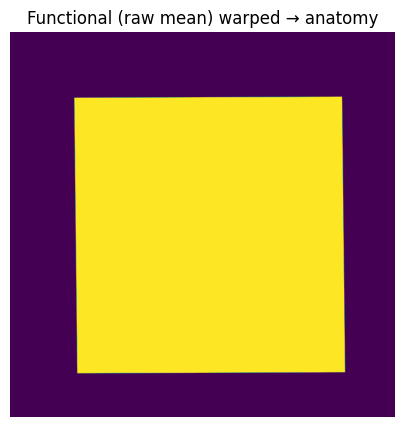

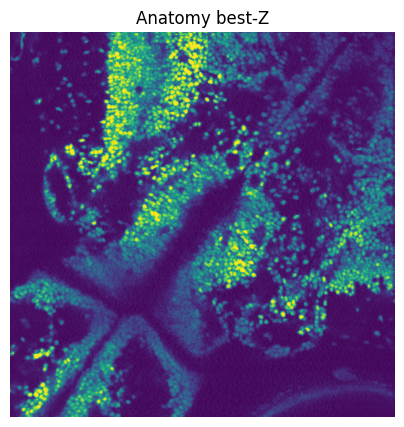

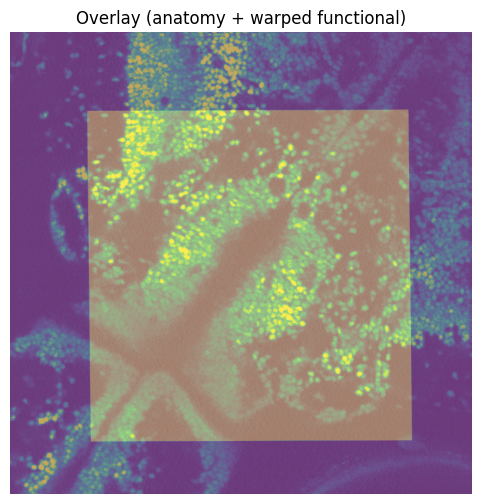

Saved transform to /Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/output/func_to_anat_affine_ecc_2x3.npy


In [9]:

# Stage 1: Similarity (rigid+scale) via ORB+RANSAC
tform_sim = estimate_inplane_transform(ref_match, anat_f[best_z], method='similarity')
print("Similarity tform:", tform_sim.params)

# Stage 2: Affine via ORB+RANSAC (optional)
tform_aff = estimate_inplane_transform(ref_match, anat_f[best_z], method='affine')
print("Affine (RANSAC) tform:", tform_aff.params)

# Stage 3: Intensity-based affine refinement (ECC) starting from the affine estimate
tform = refine_affine_ecc(ref_match, anat_f[best_z], init_tform=tform_aff, max_iters=300, eps=1e-6, pyr_levels=3)
print("Affine (ECC refined) tform:", tform.params)

# Warp the NON-normalized average into anatomy space for visual QA
ref_warped_raw = apply_transform_2d(ref2d_raw, tform, output_shape=anat_f[best_z].shape, order=1)
quickshow(norm01(ref_warped_raw), 'Functional (raw mean) warped → anatomy')
quickshow(anat_f[best_z], 'Anatomy best-Z')

# Overlay QA
plt.figure(figsize=(6,6))
plt.imshow(anat_f[best_z], alpha=0.7)
plt.imshow(norm01(ref_warped_raw), alpha=0.3)
plt.title('Overlay (anatomy + warped functional)')
plt.axis('off'); plt.show()

# Save transform matrix
np.save(OUTDIR/'func_to_anat_affine_ecc_2x3.npy', tform.params)
print("Saved transform to", OUTDIR/'func_to_anat_affine_ecc_2x3.npy')


In [10]:

# Interactive overlay: toggle channels like FIJI
try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_WIDGETS = True
except Exception as _e:
    _HAS_WIDGETS = False
    print('ipywidgets not available; skipping interactive overlay. Install ipywidgets to enable.')

# Prepare normalized views (may depend on earlier cells)
__overlay_ready = True
try:
    # Prefer warped functional reference if available; else compute a preview using the current transform; else fall back.
    if 'ref_warped' in globals() and ref_warped is not None:
        f_src = ref_warped; F_SRC_LABEL = 'warped'
    elif 'tform' in globals():
        mov_src = ref_match if 'ref_match' in globals() else (ref2d_raw if 'ref2d_raw' in globals() else ref2d)
        f_src = apply_transform_2d(mov_src, tform, output_shape=anat[best_z].shape, order=1); F_SRC_LABEL = 'tform-preview'
    else:
        f_src = ref2d; F_SRC_LABEL = 'raw'
    f_vis = norm01(f_src)
    a_vis = norm01(anat[best_z])
    # Harmonize shapes for overlay — resize functional to anatomy slice shape if needed
    if f_vis.shape != a_vis.shape:
        f_vis = transform.resize(f_vis, a_vis.shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
except Exception as _e:
    print('Interactive overlay prerequisites missing (ref2d/anat/best_z). Run previous cells first.)')
    __overlay_ready = False

# Define simple LUTs
_COLORS = {
    'green':   (0.0, 1.0, 0.0),
    'magenta': (1.0, 0.0, 1.0),
    'red':     (1.0, 0.0, 0.0),
    'blue':    (0.0, 0.0, 1.0),
    'cyan':    (0.0, 1.0, 1.0),
    'yellow':  (1.0, 1.0, 0.0),
    'white':   (1.0, 1.0, 1.0)
}

def _apply_color(gray01, rgb):
    r, g, b = rgb
    return np.stack([gray01*r, gray01*g, gray01*b], axis=-1)

def _render(show_func=True, show_anat=True, func_color='green', anat_color='magenta', func_alpha=1.0, anat_alpha=1.0):
    out = np.zeros((f_vis.shape[0], f_vis.shape[1], 3), dtype=np.float32)
    if show_anat:
        out += _apply_color(a_vis, _COLORS[anat_color]) * float(anat_alpha)
    if show_func:
        out += _apply_color(f_vis, _COLORS[func_color]) * float(func_alpha)
    out = np.clip(out, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.title(f'Overlay — func[{func_color}] alpha={func_alpha:.2f}, anat[{anat_color}] alpha={anat_alpha:.2f} | func src: {F_SRC_LABEL}')
    plt.axis('off')
    plt.show()

show_func_cb = widgets.Checkbox(value=True, description='Show functional')
show_anat_cb = widgets.Checkbox(value=True, description='Show anatomy')
func_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='green', description='Func LUT')
anat_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='magenta', description='Anat LUT')
func_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Func α')
anat_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Anat α')

if _HAS_WIDGETS and __overlay_ready:
    ui = widgets.VBox([
        widgets.HBox([show_func_cb, func_color_dd, func_alpha_sl]),
        widgets.HBox([show_anat_cb, anat_color_dd, anat_alpha_sl])
    ])
    out = widgets.interactive_output(_render, {
        'show_func': show_func_cb,
        'show_anat': show_anat_cb,
        'func_color': func_color_dd,
        'anat_color': anat_color_dd,
        'func_alpha': func_alpha_sl,
        'anat_alpha': anat_alpha_sl,
    })
    display(ui, out)
elif _HAS_WIDGETS and not __overlay_ready:
    print('Interactive overlay not shown: run best-Z cell first.')


Output()


## 3.0) Mask diameters by axis (µm)
Assess label diameters along Z, Y, X for functional, anatomy, and HCR masks.

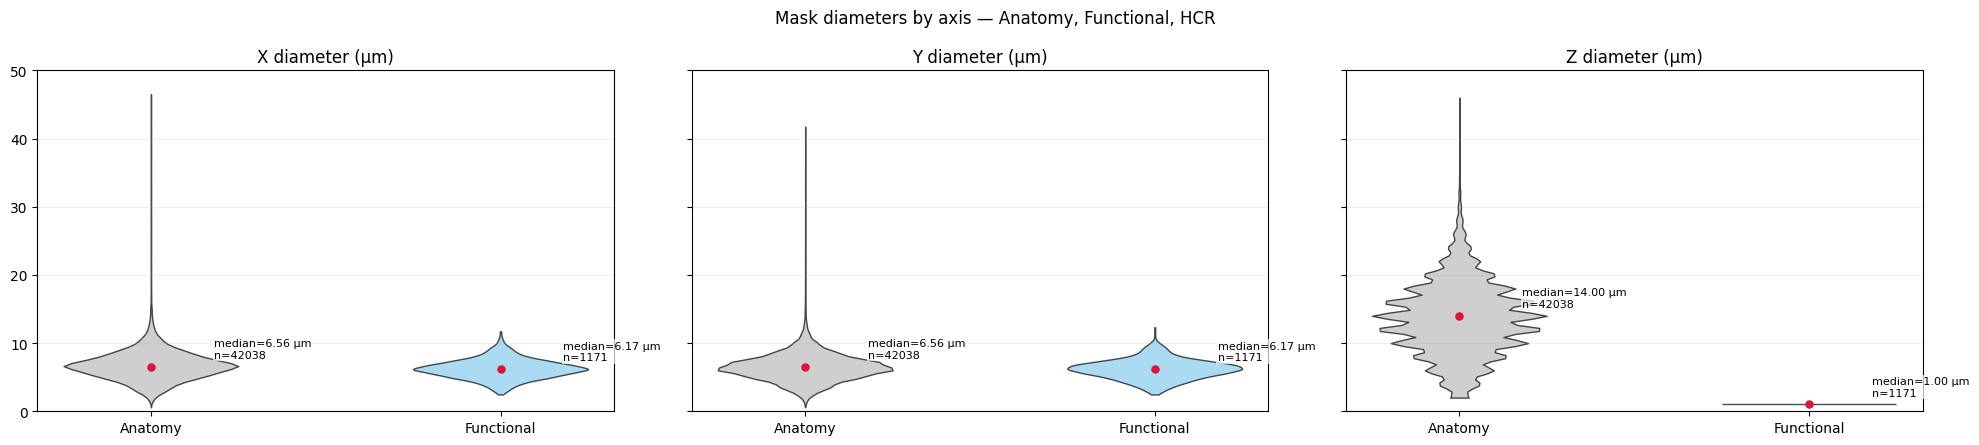

,dataset,x_median,y_median,z_median,n
0,Anatomy,6.560427,6.560427,14.0,42038
1,Functional,6.166852,6.166852,1.0,1171


In [11]:

# Mask diameters (µm) for anatomy, functional, HCR (if available)
import numpy as _np, matplotlib.pyplot as _plt

def _load_labels_or_none(path):
    if path is None:
        return None
    try:
        if not os.path.exists(path):
            return None
        arr = _ensure_uint_labels(imread(path))
        if arr.ndim == 3 and arr.shape[-1] in (3,4):
            arr = arr[...,0]
        return arr
    except Exception as _e:
        print('Could not load labels from', path, ':', _e)
        return None

dfs = []
anat_labels = _load_labels_or_none(ANAT_LABELS_PATH)
if anat_labels is not None:
    anat_3d = anat_labels if anat_labels.ndim == 3 else anat_labels[None, ...]
    vox_a = {
        'Z': float(VOX_ANAT.get('Z',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'Y': float(VOX_ANAT.get('Y',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'X': float(VOX_ANAT.get('X',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
    }
    df_anat_diam = diameters_um_from_array(anat_3d, vox_a)
    df_anat_diam['dataset'] = 'Anatomy'
    dfs.append(df_anat_diam)

func_labels = _load_labels_or_none(FUNC_LABELS_PATH)
if func_labels is not None:
    func_3d = func_labels if func_labels.ndim == 3 else func_labels[None, ...]
    vox_f = {
        'Z': 1.0,
        'Y': float(VOX_FUNC.get('Y',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
        'X': float(VOX_FUNC.get('X',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
    }
    df_func_diam = diameters_um_from_array(func_3d, vox_f)
    df_func_diam['dataset'] = 'Functional'
    dfs.append(df_func_diam)

HCR_LABELS_PATH = globals().get('HCR_LABELS_PATH', None)
hcr_labels = _load_labels_or_none(HCR_LABELS_PATH) if HCR_LABELS_PATH is not None else None
if hcr_labels is not None:
    hcr_3d = hcr_labels if hcr_labels.ndim == 3 else hcr_labels[None, ...]
    vox_h = {
        'Z': float(VOX_HCR.get('Z',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'Y': float(VOX_HCR.get('Y',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'X': float(VOX_HCR.get('X',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
    }
    df_hcr_diam = diameters_um_from_array(hcr_3d, vox_h)
    df_hcr_diam['dataset'] = 'HCR'
    dfs.append(df_hcr_diam)

if not dfs:
    print('No label volumes available for diameter analysis.')
else:
    df_all = pd.concat(dfs, ignore_index=True)
    cats_plot = ['Anatomy','Functional','HCR']
    present = [c for c in cats_plot if c in df_all['dataset'].unique()]

    def _series_for_axis(axis_col):
        ser = []
        for ds in present:
            vals = df_all.loc[df_all['dataset']==ds, axis_col].to_numpy(dtype=float)
            ser.append(vals)
        return ser

    series_x = _series_for_axis('x_um')
    series_y = _series_for_axis('y_um')
    series_z = _series_for_axis('z_um')

    all_vals = _np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any(
        (a.size for a in (series_x + series_y + series_z))) else _np.array([])
    y_max_data = float(_np.max(all_vals)) if all_vals.size else 10.0
    from math import ceil as _ceil
    y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
    yticks = _np.arange(0.0, y_max + 0.1, 10.0)

    color_map = {'Anatomy':'#bbbbbb', 'Functional':'#88ccee', 'HCR':'#cc88ff'}
    colors = [color_map.get(ds, '#cccccc') for ds in present]

    fig, axes = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
    if not hasattr(axes, '__len__'):
        axes = [axes]
    for ax, ser, title in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)']):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        x_offset = 0.18
        y_offset = 0.02 * y_max
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                med = float(_np.median(vals))
                ax.scatter([i], [med], color='crimson', zorder=3, s=26)
                label_txt = 'median={:.2f} µm\nn={:d}'.format(med, vals.size)
                ax.text(i + x_offset, med + y_offset, label_txt,
                        va='bottom', ha='left', fontsize=8, bbox=bbox_style, clip_on=False, zorder=4)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present)+1))
        ax.set_xticklabels(present, rotation=0)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.2)
    fig.suptitle('Mask diameters by axis — Anatomy, Functional, HCR')
    _plt.tight_layout()
    _plt.show()

    rows = []
    for ds in present:
        sub = df_all[df_all['dataset']==ds]
        if sub.empty:
            rows.append({'dataset': ds, 'x_median': _np.nan, 'y_median': _np.nan, 'z_median': _np.nan, 'n': 0})
        else:
            rows.append({
                'dataset': ds,
                'x_median': float(_np.median(sub['x_um'])) if len(sub['x_um']) else _np.nan,
                'y_median': float(_np.median(sub['y_um'])) if len(sub['y_um']) else _np.nan,
                'z_median': float(_np.median(sub['z_um'])) if len(sub['z_um']) else _np.nan,
                'n': int(len(sub)),
            })
    med_table = pd.DataFrame(rows)
    try:
        display(med_table)
    except Exception:
        print(med_table.to_string(index=False))



## 3.1a) Centroid distance distribution + threshold QA
Violin plot of functional→anatomy centroid distances (µm), with median and N.
Use the slider to see how many cells remain under a distance threshold.

In [16]:

# Load or compute matches if needed
if 'links_df' not in globals() or links_df is None or len(links_df)==0:
    try:
        links_df = pd.read_csv(OUTDIR/'f2a_centroid_matches.csv')
    except Exception:
        links_df = None

# Compute links_df if still missing
if (links_df is None or not len(links_df)):
    try:
        # Load labels if available
        func_labels = None; anat_labels = None
        if FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
            func_labels = _ensure_uint_labels(imread(FUNC_LABELS_PATH))
            if func_labels.ndim == 3:
                func_labels = func_labels[...,0]
        if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
            anat_labels = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
        if func_labels is None or anat_labels is None:
            raise RuntimeError('Missing FUNC_LABELS_PATH or ANAT_LABELS_PATH')
        # Ensure functional labels same size as functional reference
        if 'ref2d' in globals() and func_labels.shape != ref2d.shape:
            func_labels = transform.resize(func_labels, ref2d.shape, order=0, preserve_range=True, anti_aliasing=False).astype(func_labels.dtype)
        # Anatomy slice at best_z
        anat_labels_z = anat_labels[int(best_z)] if anat_labels.ndim==3 else anat_labels
        # Centroids
        fdf = _regionprops_centroids_2d(func_labels)
        tx, ty = _apply_tform_points_xy(tform, fdf['cx'].values, fdf['cy'].values)
        fdf['cx_t'] = tx; fdf['cy_t'] = ty
        adf = _regionprops_centroids_2d(anat_labels_z)
        # Match by Hungarian on Euclidean distance (pixels)
        F = fdf[['cx_t','cy_t']].to_numpy(); A = adf[['cx','cy']].to_numpy()
        d2 = ((F[:,None,:] - A[None,:,:])**2).sum(axis=2); D = np.sqrt(d2)
        from scipy.optimize import linear_sum_assignment as _lsa
        row_ind, col_ind = _lsa(D)
        MAX_LINK_DIST_PX = 50.0
        keep = D[row_ind, col_ind] <= MAX_LINK_DIST_PX
        row_ind = row_ind[keep]; col_ind = col_ind[keep]
        # Voxels for µm conversion
        try:
            vox_x = float(VOX_ANAT.get('X', VOX_ANAT.get(2, VOX_ANAT.get('2', 1.0))))
            vox_y = float(VOX_ANAT.get('Y', VOX_ANAT.get(1, VOX_ANAT.get('1', 1.0))))
        except Exception:
            vox_x, vox_y = 1.0, 1.0
        links = []
        for r, c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
            dist_px = float(D[r,c])
            dx_um = (fxp - axp) * vox_x; dy_um = (fyp - ayp) * vox_y
            dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
            links.append({'fx_anat_px': fxp, 'fy_anat_px': fyp, 'ax_px': axp, 'ay_px': ayp, 'dist_px': dist_px, 'dist_um': dist_um})
        import pandas as _pd
        links_df = _pd.DataFrame(links)
        if len(links_df):
            links_df.to_csv(OUTDIR/'f2a_centroid_matches.csv', index=False)
    except Exception as _e:
        print('Could not compute matches for 3.1a:', _e)

if links_df is not None and len(links_df):
    import numpy as _np, matplotlib.pyplot as _plt
    d = links_df['dist_um'].to_numpy().astype(float)
    N = int(d.size); med = float(_np.median(d))
    # Precompute background image once
    try:
        bg = norm01(anat[int(best_z)])
    except Exception:
        bg = None
    try:
        import ipywidgets as widgets
        thr_max = float(_np.percentile(d, 99)) if N>0 else 10.0
        thr_sl = widgets.FloatSlider(value=float(_np.percentile(d, 90)) if N>0 else 0.0, min=0.0, max=max(1.0, thr_max), step=0.1, description='Threshold (µm)')
        out = widgets.Output(); count_html = widgets.HTML()
        def _render(threshold):
            with out:
                out.clear_output(wait=True)
                keep_mask = d <= float(threshold); keep = int(keep_mask.sum())
                fig, (ax1, ax2) = _plt.subplots(1,2, figsize=(16,7), gridspec_kw={'width_ratios':[1,3]})
                vp = ax1.violinplot(d, showmeans=False, showmedians=False, showextrema=False)
                for pc in vp['bodies']:
                    pc.set_facecolor('#88ccee'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
                ax1.axhline(med, color='crimson', linestyle='--', linewidth=1.5, label=f'Median {med:.2f} µm')
                ax1.axhline(float(threshold), color='orange', linestyle=':', linewidth=1.5, label=f'Thresh {threshold:.2f} µm')
                ax1.set_xticks([]); ax1.set_ylabel('Centroid distance (µm)'); ax1.set_title('Centroid distances (µm)'); ax1.legend(loc='lower right')
                if bg is not None: ax2.imshow(bg, cmap='gray')
                if keep and all(col in links_df.columns for col in ('ax_px','ay_px','fx_anat_px','fy_anat_px')):
                    kept = links_df[keep_mask] if keep_mask.shape[0] == len(links_df) else links_df
                    ax2.scatter(kept['ax_px'], kept['ay_px'], s=30, c='magenta', label='Anat centroids')
                    ax2.scatter(kept['fx_anat_px'], kept['fy_anat_px'], s=30, facecolors='none', edgecolors='lime', label='Func→Anat centroids')
                    for _, row in kept.iterrows():
                        ax2.plot([row['ax_px'], row['fx_anat_px']], [row['ay_px'], row['fy_anat_px']], 'y-', alpha=0.5)
                    ax2.legend(loc='lower right')
                ax2.set_title('Kept links (≤ threshold) on anatomy'); ax2.axis('off'); _plt.tight_layout(); _plt.show()
                count_html.value = f'<b>Keep:</b> {keep} / {N} cells (≤ {float(threshold):.2f} µm)'
        ui = widgets.VBox([thr_sl, count_html, out]); widgets.interactive_output(_render, {'threshold': thr_sl}); display(ui); _render(thr_sl.value)
    except Exception as _e:
        print('ipywidgets not available; slider+dynamic overlay disabled.', _e)
else:
    print('No centroid matches to plot.')



## 3.2) 3D viewer for anatomy with overlays
Scroll Z, toggle overlays (anatomy labels, warped functional labels, and centroids).


In [17]:

try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_W = True
except Exception:
    _HAS_W = False
    print('ipywidgets not available; skipping 3D viewer.')

if _HAS_W and 'anat' in globals():
    Z = anat.shape[0] if anat.ndim == 3 else 1
    z_sl = widgets.IntSlider(value=int(best_z) if 'best_z' in globals() else 0, min=0, max=max(0,Z-1), step=1, description='Z')
    show_anat_lbl = widgets.Checkbox(value=True, description='Show anatomy labels')
    show_func_lbl = widgets.Checkbox(value=os.path.exists(OUTDIR/'func_labels_in_anat_slice.tif'), description='Show func labels (warped)')
    show_centroids = widgets.Checkbox(value=True, description='Show centroids')
    alpha_lbl = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.05, description='Label α')

    # Load for viewer (lazy)
    _anat_labels = None
    if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
        _anat_labels = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
    _func_warp = None
    fw_path = OUTDIR/'func_labels_in_anat_slice.tif'
    if os.path.exists(fw_path):
        _func_warp = _ensure_uint_labels(imread(fw_path))

    def _draw(z, show_al, show_fl, show_pts, alpha):
        sl = anat[z] if anat.ndim == 3 else anat
        plt.figure(figsize=(6,6))
        plt.imshow(norm01(sl), cmap='gray')
        if show_al and _anat_labels is not None:
            if _anat_labels.ndim == 3:
                al = _anat_labels[z]
            else:
                al = _anat_labels
            plt.imshow(al, cmap='nipy_spectral', alpha=alpha, interpolation='nearest')
        if show_fl and _func_warp is not None and z == int(best_z):
            plt.imshow(_func_warp, cmap='viridis', alpha=alpha, interpolation='nearest')
        if show_pts and os.path.exists(OUTDIR/'f2a_centroid_matches.csv') and z == int(best_z):
            df = pd.read_csv(OUTDIR/'f2a_centroid_matches.csv')
            if len(df):
                plt.scatter(df['ax_px'], df['ay_px'], s=25, c='magenta', label='Anat c')
                plt.scatter(df['fx_anat_px'], df['fy_anat_px'], s=25, facecolors='none', edgecolors='lime', label='Func→Anat c')
        plt.title(f'Anatomy Z={z}')
        plt.axis('off'); plt.show()

    out = widgets.interactive_output(_draw, {
        'z': z_sl, 'show_al': show_anat_lbl, 'show_fl': show_func_lbl, 'show_pts': show_centroids, 'alpha': alpha_lbl
    })
    ui = widgets.VBox([z_sl, widgets.HBox([show_anat_lbl, show_func_lbl, show_centroids, alpha_lbl])])
    display(ui, out)
else:
    print('3D viewer prerequisites missing (anat, ipywidgets).')


Output()


## 4) (Optional) Transfer ROI labels safely (nearest-neighbor)

If you have a label image (e.g., Cellpose IDs), warp it with **order=0** (nearest‑neighbor) to avoid fragmentation or mixing of labels.


In [14]:

if LABELS_PATH and os.path.exists(LABELS_PATH):
    labels = imread(LABELS_PATH)
    if labels.ndim == 2:
        labels_warp = resample_labels_nn(labels, tform, output_shape=anat.shape[1:])
        imwrite(OUTDIR/'labels_in_anat_space.tif', labels_warp.astype(np.uint16))
        print("Saved labels_in_anat_space.tif")
        quickshow(labels_warp>0, 'Labels (any>0) in anatomy space')
    else:
        print("LABELS_PATH is not a 2D label image; adapt code for your layout.")
else:
    print("No LABELS_PATH provided; skipping labels transfer.")


No LABELS_PATH provided; skipping labels transfer.



## 5) Apply anatomy → HCR 3D warp (hook)

Provide a function `warp3d_func(slice_img, z_index)` that applies your 3D deformation field to a 2D slice at Z.  
This is where you plug in BigWarp/ANTs/SimpleITK. Below is a **mock** that passes data through unchanged.


In [15]:

def dummy_warp3d(slice_img, z_index):
    # Replace with your BigWarp/ANTs application. This is identity.
    return slice_img

# Example usage:
slice_in_hcr = apply_anat_to_hcr_warp_2d(ref_warped, best_z, warp3d_func=dummy_warp3d)
quickshow(slice_in_hcr, 'Slice in HCR space (dummy)')


NameError: name 'ref_warped' is not defined


## 6) Save a small JSON with parameters and results


In [ ]:

meta = {
    "FUNC_STACK_PATH": str(FUNC_STACK_PATH) if 'FUNC_STACK_PATH' in globals() and FUNC_STACK_PATH else None,
    "ANAT_STACK_PATH": str(ANAT_STACK_PATH) if 'ANAT_STACK_PATH' in globals() and ANAT_STACK_PATH else None,
    "HCR_STACK_PATH": str(HCR_STACK_PATH) if 'HCR_STACK_PATH' in globals() and HCR_STACK_PATH else None,
    "best_z": int(best_z),
    "transform_params_2x3": tform.params.tolist(),
    "ref_build_strategy": str(REF_BUILD_STRATEGY) if 'REF_BUILD_STRATEGY' in globals() else None,
    "voxels": {"func": VOX_FUNC, "anat": VOX_ANAT, "hcr": VOX_HCR},
    "voxel_cache": str(VOX_CACHE_PATH) if 'VOX_CACHE_PATH' in globals() else None,
    "rng_seed": RNG_SEED,
}

with open(OUTDIR/'run_metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Wrote", OUTDIR/'run_metadata.json')



## Notes & next steps

- If the NCC best‑Z curve is **broad** or has multiple peaks, consider matching a **slab** (±2–3 slices) instead of a single slice.
- For in‑plane alignment, try `method='affine'` if you suspect slight shear/scale differences.
- To register **anatomy → HCR** in Python, consider:
  - **SimpleITK (Elastix)**: rigid→affine→B‑spline with mutual information.
  - **ANTsPy**: SyN-based deformable registration.
- Once you have a 3D transform, apply it to **grayscale** with linear order, to **labels** with nearest‑neighbor.
- Compose transforms and resample once if you can (functional → anatomy → HCR → output).